<a href="https://colab.research.google.com/github/sanket-kumar-sunny/Project-ML/blob/master/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-End Multi-class Dog Breed Classification
 
 This notebook builds an end-to-end multi-class image classifier using TensorFlow 2. and Tensorflow Hub.

 ## 1. Problem

Identifying the breed of a dog given an image of a dog.

When I'm sitting in a cafe and I take a photo of a dog, want to know what breed of dog it is.
 ## 2. Data

The data we're using is from Kaggle's dog breed identificaion competition:

https://www.kaggle.com/c/dog-breed-identification/data


 ## 3. Evaluation

The evaluations is a file with prediction probabilities for each dog bread of each test image:

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

 ## 4. Features

 Some information about the data:
 * We're dealing with the images(unstructured data) so it's probably best we use deep learning/transfer learning.
 * There are 120 breeds of dogs (This means there hundreds of different classes
 * There are around 10,000+ images in training set (These images have labels)
 * There are aroung 10,000+ images in test set (These images has no labels, because we want to predict them.)
 

In [1]:
#Unzip the uploaded data into Google Drive
#!unzip "drive/My Drive/Dog Vision/dog-breed-identification.zip" -d "drive/My Drive/Dog Vision/"

### Get our workspace ready

* Import Tensorflow 2.x
* Import Tensorflow Hub
* Make sure we're using a GPU (Because data is very large...hence we need higher processeing power)

In [2]:
# Import Tensorflow into Colab

import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF Hub Version:", hub.__version__)

# Check for GPU avaialability
print("GPU", "available (YeSSSS!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.3.0
TF Hub Version: 0.9.0
GPU available (YeSSSS!!!)


## Getting our data ready (turning into tensors)

With all machine learning models, our data has to be in numerical format, So that's what we are doing is turning all the images into tensors(numerical representations).

Let's start by accessing our data and checking out labels.


In [3]:
  # Checkout the labels of our data
  import pandas as pd
  labels_csv= pd.read_csv('drive/My Drive/Dog Vision/labels.csv')
  print(labels_csv.describe())
  print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     d91761b9302c37487710a4d8f890ba97  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [4]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [5]:
# How many images are there for each breed?
labels_csv["breed"].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
brabancon_griffon        67
golden_retriever         67
komondor                 67
briard                   66
eskimo_dog               66
Name: breed, Length: 120, dtype: int64

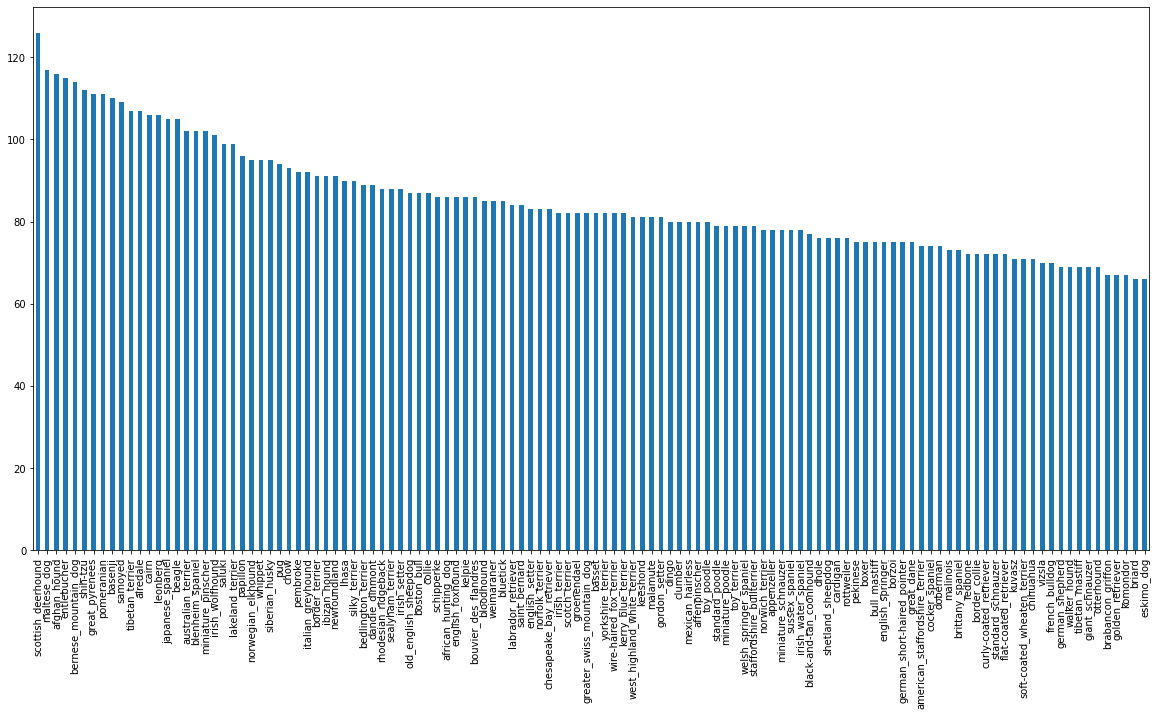

In [6]:
# Lets visualise this
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10))

In [7]:
labels_csv["breed"].value_counts().mean(), labels_csv["breed"].value_counts().median()

(85.18333333333334, 82.0)

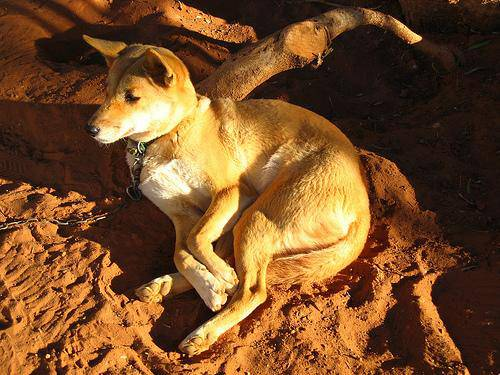

In [8]:
# Let's view an image
from IPython.display import Image
Image("drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

In [9]:
# Create the path  name for ID's
filenames = ["drive/My Drive/Dog Vision/train/"+ fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10
filenames[:10]

['drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [10]:
# Check whether number of filesnames matches number of actual images files
import os

if len(os.listdir("drive/My Drive/Dog Vision/train/")) == len(filenames):
  print("Filenames match actual amount of files !!! Proceed..")
else:
  print("filenames do not match amount of files , check the target directory")

Filenames match actual amount of files !!! Proceed..


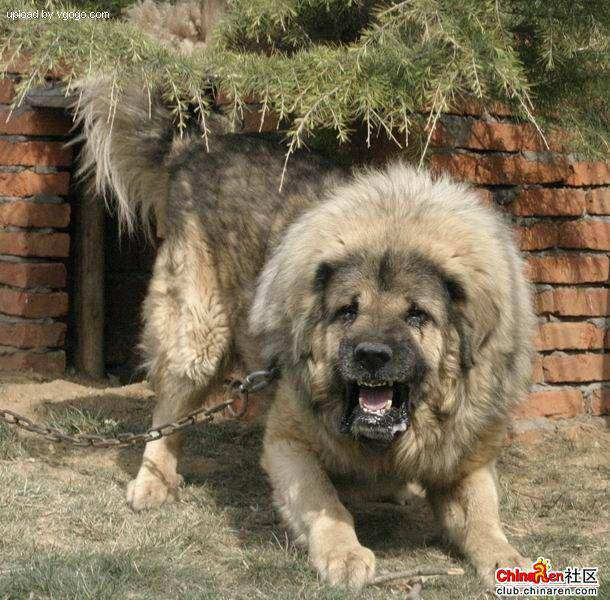

In [11]:
# One more check 
Image(filenames[9000])

In [12]:
labels_csv["breed"][9000]

'tibetan_mastiff'

Since we have got our training image filepaths in a list, let's prepare our labels.

In [13]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
# labels= np.array(labels) # Does same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [14]:
len(labels)

10222

In [15]:
# Check if the labels matches the number of filesnames:
if len(labels) == len(filenames):
  print("The number of files in label matches the number of filesname list")
else:
  print("The number of file in labels does not maches the number of files!!")

The number of files in label matches the number of filesname list


In [16]:
# Find the unique label values
unique_breeds=np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [17]:
len(unique_breeds)

120

In [18]:
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [19]:
# Turn the single array into array of boolean
print(labels[0])
print(labels[0]==unique_breeds)

boston_bull
[False False False False False False False False False False False False
 False False False False False False False  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]


In [20]:
# Turn every label into boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [21]:
len(boolean_labels)

10222

In [22]:
# Example: turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # Index where label occurs in a boolean array
print(boolean_labels[0].astype(int)) # There will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [23]:
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [24]:
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [25]:
filenames[:10]

['drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

### Creating our won validation set
Since dataset from Kaggle doesn't come with validation set, we are going to create our own. 


In [26]:
# Setup X & y variables 
X = filenames
y = boolean_labels

In [27]:
len(filenames)

10222

We are going to start off experimenting with -1000 images and increases as needed.


In [28]:
#Set number of images use for experimenting
NUM_IMAGES = 1000 # @param {type:"slider", min:1000, max:10000, step:1000} 

In [29]:
# Lets split our data into train and validtion sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], 
                                                     y[:NUM_IMAGES],
                                                     test_size=0.20,
                                                     random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [30]:
# Let's have a geez at the training data
X_train[:5], y_train[:5]

(['drive/My Drive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/My Drive/Dog Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/My Drive/Dog Vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/My Drive/Dog Vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, Fa

## Preprocessing Images (turning images into Tensors)

to preprocess our images into Tensors we are going to write a function which does a few things:

* 1. Take an image filepath as input
* 2. Use Tensorflow to read the file and save it to a variable, `image`
* 3. Turn our `image` (a jpg) into Tensors
* 4. Resize the `image` to be a shape of (224, 224)
* 5. Return the modified `image`

Before we do.. let's see what importing images looks like

In [31]:
# Converting images to numpy array
from matplotlib.pyplot import imread
image= imread(filenames[42])
image.shape

(257, 350, 3)

In [32]:
image.max(), image.min()

(255, 0)

In [33]:
image[:2]

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)

In [34]:
# Turn image into tensor
tf.constant(image)[:2] 
# there is no diference between image[:2] and td.constant(image)[:2].. its only conversion of image in tensor so that we can run image file in GPU very fast

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

In [35]:
np.mean([10,20,30,50])

27.5

Now we have seen what an image looks like in Tensor, lets make a function to preprocess them.

1. Take an image filepath as input
2. Use Tensorflow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our image (convert colour channel values from from 0-255 to 0-1).
4. Resize the `image` to be a shape of (224, 224)
5. Return the modified `image`

In [36]:
# Define Image size
IMG_SIZE = 224

#Create the function for preprocessing as a image
def process_image(image_path, img_size = IMG_SIZE):
  """
  Takes an image path and turns image into a Tensor
  """
  # Read in an image file
  image = tf.io.read_file(image_path) #To know what it actually does.. then go to below cell

  # Turn the jpeg image into numerical Tensor with 3 colour channels (Read, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3) #To know what it actually does.. then go two cell below

  # Convert the colour channels values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size= [IMG_SIZE, IMG_SIZE])

  return image

In [37]:
tensor = tf.io.read_file(filenames[26])
tensor

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\n\x07\x07\x08\x07\x06\n\x08\x08\x08\x0b\n\n\x0b\x0e\x18\x10\x0e\r\r\x0e\x1d\x15\x16\x11\x18#\x1f%$"\x1f"!&+7/&)4)!"0A149;>>>%.DIC<H7=>;\xff\xdb\x00C\x01\n\x0b\x0b\x0e\r\x0e\x1c\x10\x10\x1c;("(;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;\xff\xc0\x00\x11\x08\x01\xf4\x01w\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca

## Turning our data into batches

Why turn our data into batches?

Let's say we are trying to process 10,000+ images in one go... they all might not fit into the memory.
So we will create the batch of 32 images at a time (we can manually adjust the size of batch if needed).

In order to use TensorFlow effectively, we need our data in the need of Tensor tuple which look like this: (image, labels)

In [38]:
# Before we get a batch of 32, first we need tuple.
# So creating a simple function to return tuple

def get_image_label(image_path, label):
  """
  Take an image file path name and the associated label,
  processes the image and returns a tuple of (image, label)
  """
  image = process_image(image_path)
  return image, label

In [39]:
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we have got a way to turn our data into tuples of Tensors in the form: (image, label), let's make a fuctions to turn all of our data (X & y) into batches!! 

In [40]:
# Define a batch size, 32 is good start
BATCH_SIZE = 32

#Create a function to turn data into batches 
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data = False, test_data = False ):
  """
  Create batches of data out of images (X) and label (y) pairs.
  Shuffle the data if its training data ..but dont shuffle the data if its validation data..
  Also accept test data as input data (no labels)
  """

  # If data is test dataset , we probably dont have labels

  if test_data:
    print ("Creating test data batches ....")
    data= tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepath (no labels)
    data_batch=data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is valid dataset, we dont need to shuffle it
  elif valid_data:
    print("Creating valid data batches....")
    data= tf.data.Dataset.from_tensor_slices((tf.constant(X), #filepath
                                              tf.constant(y))) # labels
    
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Create training data batches....")
    
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                                tf.constant(y)))
    # Shuffling path names and labels before mapping image preocessor functions is faster than shuffling imgaes.
    data = data.shuffle(buffer_size=len(X))

    # Creating (image, label) tuples(this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
    
  return data_batch


In [41]:
# Create training and validation data batches 
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Create training data batches....
Creating valid data batches....


In [42]:
# Check out the attributes of our data batches

train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [43]:
y[0], len(y[0])

(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]), 120)

## Visualizing Data Batches 

Our data is now in batches, however, these can be little hard to understand/comprehend. Let's visualize them!!

In [44]:
import matplotlib.pyplot as plt

#Create  a function a viewing images  is data batches

def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from data batch
  """

  # Setup the figure 
  plt.figure(figsize=(10, 10))

  #Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax=plt.subplot(5, 5, i+1)

    #Display the image
    plt.imshow(image[i])

    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])

    #Turn the grid lines off
    plt.axis("off")


In [45]:
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [46]:
train_images, train_labels = next(train_data.as_numpy_iterator())
len(train_images), len(train_labels), train_images, train_labels

(32, 32, array([[[[7.64196217e-01, 7.60274649e-01, 7.91647196e-01],
          [7.62056291e-01, 7.58134723e-01, 7.87873805e-01],
          [7.62570083e-01, 7.58648515e-01, 7.82177925e-01],
          ...,
          [5.52146018e-01, 6.56102598e-01, 7.73749709e-01],
          [5.38217843e-01, 6.46242142e-01, 7.38206327e-01],
          [5.38217843e-01, 6.46465659e-01, 7.32963681e-01]],
 
         [[8.08059394e-01, 8.04137826e-01, 8.29733074e-01],
          [8.11344624e-01, 8.07423055e-01, 8.31266046e-01],
          [8.15498292e-01, 8.11576724e-01, 8.32217515e-01],
          ...,
          [5.69450319e-01, 6.64600849e-01, 7.76006460e-01],
          [5.46953797e-01, 6.46182716e-01, 7.32299626e-01],
          [5.46953797e-01, 6.46422505e-01, 7.30718613e-01]],
 
         [[8.29236746e-01, 8.27100933e-01, 8.48844588e-01],
          [8.32563102e-01, 8.30427289e-01, 8.49601924e-01],
          [8.40351999e-01, 8.38216126e-01, 8.55145395e-01],
          ...,
          [5.98722041e-01, 6.72689080e-01

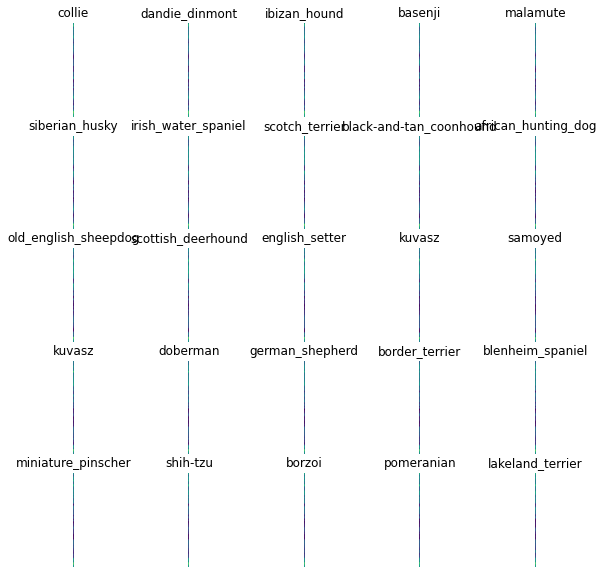

In [47]:
# Now lets visualize the data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

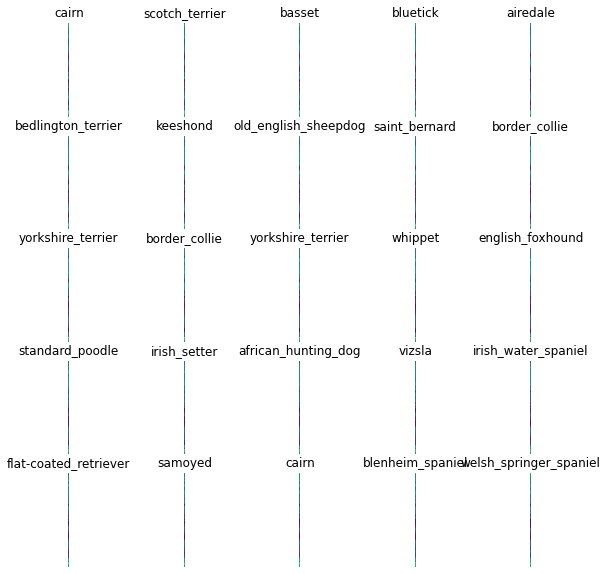

In [48]:
# Now lets visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building model

Before we build model, there are a few things we need to define:

* The input shape (our images shape, in the form of Tensors) to our model
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want use from Tensorflow Hub- https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

In [49]:
IMG_SIZE

224

In [50]:
# Setup input shape to the model

INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels 

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [51]:
2+3

5

Now we've got our inputs, outputs and model ready to go. Let's put them together into Keras deep learning model.

Knowing this, let's create a function which:
* Takes the input shape, output shape and model we have chosen as parameters
* Defines the layers in a Keras model in sequential fashion (do this first, then this, then that)
* Compiles the model (says it should be evaluated and improved)
* Build the model (tells the model the input shape it will be getting)
* Return the model

All of the steps can be found here :
https://www.tensorflow.org/guide/keras/sequential_model

In [52]:
# Create a function which builds a Keras Model
def create_model(input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE, model_url = MODEL_URL):
  print("Building Model with", MODEL_URL)

  # Setup the model layers
  model=tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), #Layer 1 (input Layer)
    tf.keras.layers.Dense(units= OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output Layer)
    ]) 
  
  # COmpile the model
  model.compile(
      loss= tf.keras.losses.CategoricalCrossentropy(),
      optimizer= tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )
  
  # Build a model
  model.build(INPUT_SHAPE)
  return model

In [53]:
model = create_model()
model.summary()

Building Model with https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## creating Callbacks

Callbacks are helper function a model can use during training to do such things as we save its progress, check its progress or stop training early if a model stop improving.

We will create two callbackss, one for TensorBoard which helps tracks our model progress and another for early stopping which prevent our model training for too long.

### TensorBoard Callbacks

To setup a TensorBoard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to model's `fit()` function.
3. Visualize our models training logs with the `%tensorboard` magic function ( we'll do after model training )

In [54]:
# Load TensorBoard notebook Extension
%load_ext tensorboard



In [55]:
import datetime

# Create a function to build a TensorBoard Callback

def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/My Drive/Dog Vision/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

# Early Stopping Callback

Early Stopping callback helps us to stop our model from overfitting by stopping training if a certain evuation metrics stop improving.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [56]:
# Create Early stopping Callback

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)
early_stopping

# Training a model (on subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.

In [57]:
NUM_EPOCHS = 10 #@param {type: "slider", min:10, max:100, steps:10}

In [58]:
# Check to make sure we're still running on a GPU
print("GPU", "available (YESSS!!!!!)" if tf.config.list_physical_devices("GPU") else "not available :()") 

GPU available (YESSS!!!!!)


Let's create a fucntion which trains a model

* Create a model using 'create_model()'
* Setup a TensorBoard callback using 'create_tensorboard_callback()'
* Call the fit() funtion on our model passing it the training data, validation data, number of epochs to train for ( NUM_EPOCHS ) and the callbacks we'd like to use.
* Retrun the model

In [59]:
# Build the funtion to train and return a trained model

def train_model():
  """
  Trains a given model and retuns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x= train_data, 
            epochs= NUM_EPOCHS,
            validation_data= val_data,
            validation_freq= 1,
            callbacks= [tensorboard, early_stopping])
  # Retrun the fitting model
  return model

In [60]:
# Fit the model to the data
model= train_model()

Building Model with https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/10
 1/25 [>.............................] - ETA: 0s - loss: 6.0738 - accuracy: 0.0000e+00WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


25/25 [==============================] - 485s 19s/step - loss: 4.7370 - accuracy: 0.0900 - val_loss: 3.4854 - val_accuracy: 0.2800
Epoch 2/10
25/25 [==============================] - 4s 154ms/step - loss: 1.7352 - accuracy: 0.6662 - val_loss: 2.1131 - val_accuracy: 0.5250
Epoch 3/10
25/25 [==============================] - 4s 151ms/step - loss: 0.5919 - accuracy: 0.9300 - val_loss: 1.6677 - val_accuracy: 0.5950
Epoch 4/10
25/25 [==============================] - 4s 154ms/step - loss: 0.2621 - accuracy: 0.9825 - val_loss: 1.4838 - val_accuracy: 0.6250
Epoch 5/10
25/25 [==============================] - 4s 152ms/step - loss: 0.1490 - accuracy: 0.9975 - val_loss: 1.3995 - val_accuracy: 0.6450
Epoch 6/10
25/25 [==============================] - 4s 152ms/step - loss: 0.1019 - accuracy: 1.0000 - val_loss: 1.3567 - val_accuracy: 0.6450
Epoch 7/10
25/25 [==============================] - 4s 151ms/step - loss: 0.0765 - accuracy: 1.0000 - val_loss: 1.3347 - val_accuracy: 0.6550
Epoch 8/10
25/25 

**Question:** It looks like our model is overfitting because it's performing far better on the training dataset than the validation dataset, what are some ways to prevent model overfitting in deep learning neural network?

Note: Overfitting in the beginning is good thing!! It clearly our model is learning.

# checking the Tensorboard logs

The Tensorboard magic function (`%tensorboard`) will be access the logs directory we created earlier and visulise the contents.

In [61]:
%tensorboard --logdir drive/My\ Drive/Dog\ Vision/logs

<IPython.core.display.Javascript object>

# Making and evaluating predictions using trained model

In [62]:
val_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [63]:
# Making prediction on validation data (not use to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 1s 98ms/step


array([[8.0328097e-04, 1.1144797e-04, 3.1532662e-03, ..., 2.1264121e-04,
        1.2768344e-05, 5.1732492e-03],
       [3.6336679e-04, 1.4347033e-04, 2.6214446e-03, ..., 2.2410379e-04,
        6.1069196e-04, 1.8991566e-04],
       [2.9284051e-06, 2.3392549e-04, 1.0848956e-03, ..., 1.2490310e-04,
        3.9026010e-05, 1.3317486e-03],
       ...,
       [2.2006167e-05, 1.1501803e-05, 7.7387573e-05, ..., 6.8856847e-05,
        3.4771627e-04, 1.6698006e-05],
       [1.1993513e-02, 9.0311201e-05, 5.6136347e-04, ..., 4.8214485e-04,
        8.5648164e-05, 3.1164752e-02],
       [1.9505192e-04, 1.6935264e-05, 2.1354036e-04, ..., 2.0487851e-03,
        1.5009330e-04, 5.0885588e-05]], dtype=float32)

In [64]:
predictions.shape

(200, 120)

In [65]:
np.sum(predictions[0])

1.0

In [66]:
len(y_val)

200

In [67]:
np.sum(predictions[1])

0.9999999

In [68]:
predictions[0]

array([8.03280971e-04, 1.11447967e-04, 3.15326615e-03, 1.08140186e-04,
       1.91402098e-04, 9.16412027e-05, 3.74668697e-03, 1.86338229e-03,
       1.48879786e-04, 8.12948565e-04, 7.10121763e-04, 7.15754068e-05,
       8.59074469e-04, 9.08304573e-05, 2.92360899e-04, 1.43887172e-03,
       7.07219413e-04, 1.51360288e-01, 3.48227732e-05, 2.79989705e-04,
       5.72090968e-04, 9.53145500e-05, 2.65325016e-05, 4.32732777e-04,
       2.24649906e-04, 1.15413728e-04, 1.32440925e-01, 4.25635604e-04,
       4.83052019e-04, 6.42176237e-05, 5.97950529e-05, 1.22155703e-03,
       9.11936149e-05, 1.61436023e-04, 2.40837704e-04, 4.60238606e-02,
       1.98861053e-05, 1.09099718e-04, 2.01988041e-05, 9.66321022e-05,
       2.72931694e-03, 6.62877792e-05, 2.29992675e-05, 3.09344090e-04,
       4.58309332e-05, 2.83943198e-04, 1.07278465e-04, 3.49123380e-04,
       7.17140094e-04, 9.77937307e-05, 9.37870354e-05, 4.12591180e-05,
       2.81380169e-04, 6.04654051e-05, 1.12137648e-04, 1.02067293e-04,
      

In [69]:
# First Predictions

index = 42
print(f'Max value (probability of prediction): {np.max(predictions[index])}')
print(f"Sum:{np.sum(predictions[index])}")
print(f"Max Index: {np.argmax(predictions[index])}")
print(f"Predficted Label: {unique_breeds [np.argmax(predictions[index])]}")

Max value (probability of prediction): 0.5762132406234741
Sum:1.0
Max Index: 113
Predficted Label: walker_hound


In [70]:
predictions[42]

array([3.8274484e-05, 1.1664440e-04, 9.6934367e-05, 1.9331533e-04,
       3.0689705e-03, 1.0735593e-04, 9.2884897e-05, 7.0598745e-04,
       1.0116619e-02, 9.8904468e-02, 1.6899376e-05, 5.7788584e-06,
       4.3181176e-04, 2.2939893e-03, 1.4349566e-03, 5.5688359e-03,
       3.9050437e-04, 5.5308262e-04, 4.6817837e-05, 2.9089936e-04,
       2.1350164e-04, 7.8945194e-04, 4.5970657e-05, 1.9111070e-04,
       1.3258122e-02, 1.3745969e-04, 9.1864058e-05, 5.0885075e-05,
       1.6300922e-04, 4.1354444e-05, 1.4410214e-04, 1.1960189e-04,
       4.0536554e-05, 4.5517532e-05, 9.2805029e-05, 5.2977899e-05,
       5.1235652e-04, 1.9688229e-04, 8.5987267e-05, 2.4943431e-01,
       8.1647711e-04, 6.9350637e-05, 5.0304532e-03, 2.0430527e-05,
       1.6676191e-04, 6.2707652e-05, 1.0337157e-04, 3.3314349e-04,
       8.7714157e-05, 9.2534639e-04, 9.4458628e-05, 1.0463676e-04,
       9.5290212e-05, 5.9191198e-03, 3.5402638e-05, 1.6418919e-04,
       7.6343858e-05, 1.4462724e-04, 4.4584220e-05, 2.7751934e

In [71]:
unique_breeds[113]

'walker_hound'

Having the above functionality is great but we want to able to do it scale.
And it would be even better if we could see the image predictions is made on !

**Note** Prediction probabilities are also known as confidence level


In [72]:
# Turn prediction probabilities into their repective label (easier to understand)

def get_pred_label(prediction_probabilities):
  """
  Turn an array of predictions probabilities into a label
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get predicted label based on array of predictions probabilities
pred_label = get_pred_label(predictions[81])
pred_label

'golden_retriever'

In [73]:
val_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

Now Since our validation data is still in a batch dataset, we'll have unbatchify it to make prediction on validation images and then compare thoe predictions to validation to the validation labels (truth labels)

In [74]:
# images_ = []
# labels_ = []

# # Loop through unbatched data
# for image, label in val_data.unbatch().as_numpy_iterator():
#   images_.append(image)
#   labels_.append(label)

# images_[0], labels_[0]

In [75]:
#get_pred_label(labels_[0])

In [76]:
# get_pred_label(predictions[0])

In [77]:
# Now creating a function to unbacth a batch dataset. What I'm doing is already the mechanisms are defined above but intgrating in one functions

def unbatchify(data):
  """
  Take a batchset dataset of (image, label) Tensors an return separate arrays of images and labels.
  """

  images= []
  labels= []

  # Loop through unbatch data
  for image, label in val_data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])

  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [78]:
get_pred_label(predictions[0])

'tibetan_terrier'

Now we have got ways to get:

* Prediction labels
* Validation Labels
* Validation images

Let's make some fucntions to make these all a bit more visualize.

We'll create a function which :

* takes an array of prediction probabilities, an array of truth labels and an array of images and integers
* Convert the  prediction probabilities to a redicted label
* Plot the predicted label, its predicted probabilities, the truth label and the target image on a single plot.



In [79]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction , ground truth and images for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)
  
  # Plot images and remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  #Changing the color of pred_label and true_label
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"



  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
            color=color)

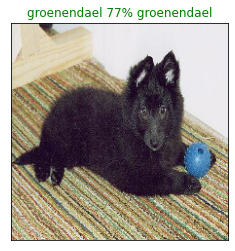

In [80]:
plot_pred(prediction_probabilities=predictions,
            labels= val_labels,
            images= val_images,
          n=77)

Now we have got one function to visualize our models top predictions, lets make another to view our model top 10 predictions.

This functions will :

* Take an input of prediction probabilities array and a ground truth and an integer.
* Find prediction using `get_pred_label()`
* Find the top 10:
  * Prediction probabilities index
  * Prediction probabilities values
  * Prediciton labels

* Plot the top 10 prediction probability values and labels, colouring the true label green

In [81]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest predictions 
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  #Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]

  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]

  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels = top_10_pred_labels,
             rotation = "vertical")
  
  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

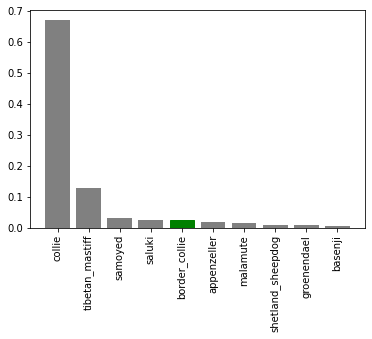

In [82]:
plot_pred_conf(prediction_probabilities=predictions,
               labels = val_labels,
               n=9)

No we have some function to help us visualize our prediction evaluate  our model, let's check out.

In [83]:
predictions[0]

array([8.03280971e-04, 1.11447967e-04, 3.15326615e-03, 1.08140186e-04,
       1.91402098e-04, 9.16412027e-05, 3.74668697e-03, 1.86338229e-03,
       1.48879786e-04, 8.12948565e-04, 7.10121763e-04, 7.15754068e-05,
       8.59074469e-04, 9.08304573e-05, 2.92360899e-04, 1.43887172e-03,
       7.07219413e-04, 1.51360288e-01, 3.48227732e-05, 2.79989705e-04,
       5.72090968e-04, 9.53145500e-05, 2.65325016e-05, 4.32732777e-04,
       2.24649906e-04, 1.15413728e-04, 1.32440925e-01, 4.25635604e-04,
       4.83052019e-04, 6.42176237e-05, 5.97950529e-05, 1.22155703e-03,
       9.11936149e-05, 1.61436023e-04, 2.40837704e-04, 4.60238606e-02,
       1.98861053e-05, 1.09099718e-04, 2.01988041e-05, 9.66321022e-05,
       2.72931694e-03, 6.62877792e-05, 2.29992675e-05, 3.09344090e-04,
       4.58309332e-05, 2.83943198e-04, 1.07278465e-04, 3.49123380e-04,
       7.17140094e-04, 9.77937307e-05, 9.37870354e-05, 4.12591180e-05,
       2.81380169e-04, 6.04654051e-05, 1.12137648e-04, 1.02067293e-04,
      

In [84]:
predictions[0][predictions[0].argsort()[-10:][::-1]]

array([0.15725566, 0.15136029, 0.13244092, 0.11404112, 0.10825478,
       0.04870205, 0.04602386, 0.04130079, 0.03953396, 0.02233401],
      dtype=float32)

In [85]:
predictions[0].max()

0.15725566

No we have some function to help us visualize our prediction evaluate our model, let's check out.

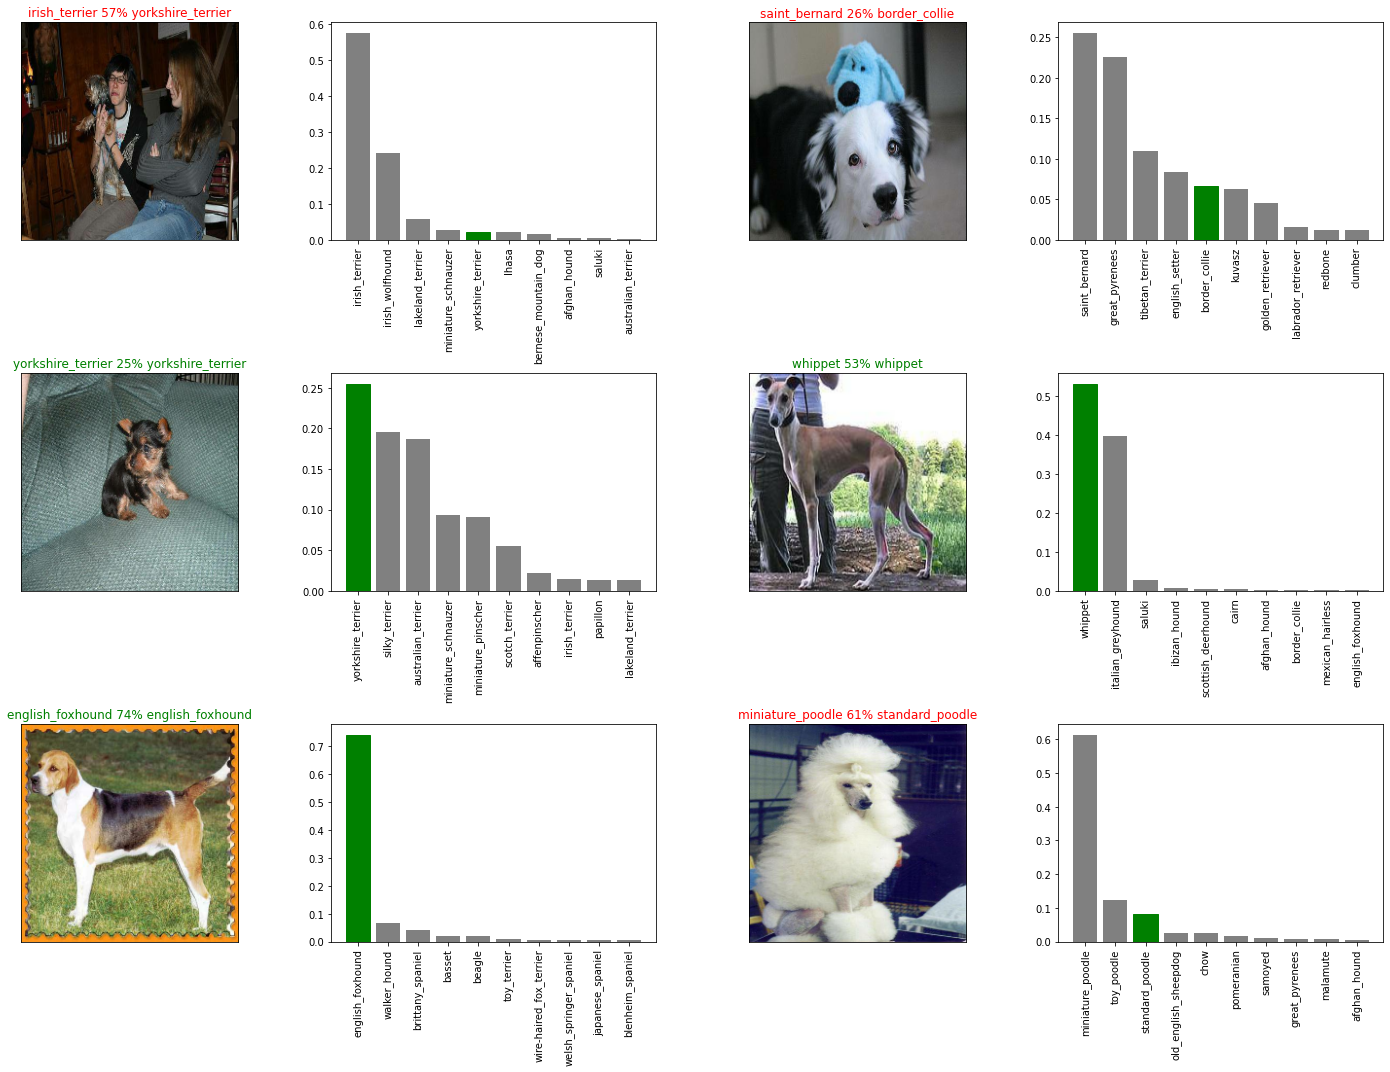

In [86]:
# Let's check out a few predictions and their different values
i_multiplier = 10
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize = (10*num_cols, 5*num_rows))
for i in range (num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities = predictions,
            labels = val_labels,
            images = val_images,
            n = i+i_multiplier)
  
  # This is for histogram grah
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities = predictions,
                 labels = val_labels,
                 n = i+i_multiplier)

plt.tight_layout(h_pad = 1.0)
plt.show()

**Challenge:**
How would you create a confusion matrix with our model predictions and true labels?

(find it by yourself an share it in discord chat)

# Saving and Reloading Model


In [87]:
# Create a function to save a model
def save_model(model, suffix= None):
  """
  Saves a given model in a model directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/My Drive/Dog Vision/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path =  modeldir + "-" + suffix + ".h5" # save format of model
  print(f"saving model to: {model_path}...")
  model.save(model_path)
  return model

In [88]:

# Create a functions to train a load model
def load_model(model_path):
  """
  Load a saved model from a specisied path.
  """
  print(f"Loading a saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects = {"KerasLayer":hub.KerasLayer})
  return model


Mow we'have got functions to save and load a trained model, let's make sure they work!!

In [89]:
# Save our model trained on 1000 image
save_model(model, suffix = "1000-images-mobilenetv2-Adas")

saving model to: drive/My Drive/Dog Vision/models/20200907-16391599496776-1000-images-mobilenetv2-Adas.h5...


In [90]:
# Load a trained model
loaded_1000_image_model = load_model("drive/My Drive/Dog Vision/models/20200906-06201599373243-1000-images-mobilenetv2-Adas.h5")

Loading a saved model from: drive/My Drive/Dog Vision/models/20200906-06201599373243-1000-images-mobilenetv2-Adas.h5


In [91]:
# Evaluate pre saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 84ms/step - loss: 1.2794 - accuracy: 0.6850


[1.2793620824813843, 0.6850000023841858]

In [92]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 1s 95ms/step - loss: 1.3140 - accuracy: 0.6650


[1.3140020370483398, 0.6650000214576721]

# Training a big dog model (on the full data)

In [93]:
len(X), len(y)

(10222, 10222)

In [94]:
X[:10]

['drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [95]:
X_train[:10]

['drive/My Drive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
 'drive/My Drive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
 'drive/My Drive/Dog Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
 'drive/My Drive/Dog Vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
 'drive/My Drive/Dog Vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg',
 'drive/My Drive/Dog Vision/train/0ea5759640f2e1c2d1a06adaf8a54ca7.jpg',
 'drive/My Drive/Dog Vision/train/03e1d2ee5fd90aef036c90a9e7f81177.jpg',
 'drive/My Drive/Dog Vision/train/16941a6728ddb9cb7423a6cc97fbe071.jpg',
 'drive/My Drive/Dog Vision/train/0bedbecd92390ef9f4f7c8b06a629340.jpg',
 'drive/My Drive/Dog Vision/train/143b9484273e57668d03bfc26755810a.jpg']

In [96]:
len(X_train)

800

In [97]:
y[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [98]:
# Creata a data batch with full data set
full_data = create_data_batches(X, y)

Create training data batches....


In [99]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [100]:
# Create a model for full model
full_model = create_model()

Building Model with https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [101]:
# Create full model callback
full_model_tensorboard = create_tensorboard_callback()

# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "accuracy",
                                                             patience = 3)

In [102]:
# Fit the full model to the full data
full_model.fit(x = full_data,
               epochs = 100,
               callbacks = [full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 5106s 16s/step - loss: 1.3811 - accuracy: 0.6590
Epoch 2/100
320/320 [==============================] - 36s 111ms/step - loss: 0.3993 - accuracy: 0.8852
Epoch 3/100
320/320 [==============================] - 35s 109ms/step - loss: 0.2337 - accuracy: 0.9347
Epoch 4/100
320/320 [==============================] - 34s 108ms/step - loss: 0.1530 - accuracy: 0.9593
Epoch 5/100
320/320 [==============================] - 35s 109ms/step - loss: 0.1078 - accuracy: 0.9790
Epoch 6/100
320/320 [==============================] - 35s 108ms/step - loss: 0.0763 - accuracy: 0.9871
Epoch 7/100
320/320 [==============================] - 35s 109ms/step - loss: 0.0583 - accuracy: 0.9918
Epoch 8/100
320/320 [==============================] - 35s 109ms/step - loss: 0.0462 - accuracy: 0.9950
Epoch 9/100
320/320 [==============================] - 35s 110ms/step - loss: 0.0368 - accuracy: 0.9966
Epoch 10/100
320/320 [==============================] - 35s 110m

In [103]:
save_model(full_model, suffix = "full-image-set-mobilenetv2-Adam")

saving model to: drive/My Drive/Dog Vision/models/20200907-18171599502659-full-image-set-mobilenetv2-Adam.h5...


In [104]:
# Load in the full model

loaded_full_model = load_model("drive/My Drive/Dog Vision/models/20200907-05161599455795-full-image-set-mobilenetv2-Adam.h5")

Loading a saved model from: drive/My Drive/Dog Vision/models/20200907-05161599455795-full-image-set-mobilenetv2-Adam.h5


## Making predictions on test dataset

Since our image is trained in the form of Tensor batches, to make predictions on the test data, we will have to get it into the same format.

Luckily we created `create_data_batches()` earlier which can take a list of filenames as input and convert them into Tensors batches.

To make predictions on the test data, we'll:

  * Get the test image filenames.
  * Convert the filenames into test data batches using 'create_the_batches()' and setting the `test_data` parameter to `True` (since the test data doesnt have labels).
  * Make the predictions array by passing the test batches to `predict()` method call our model.

In [105]:
# Load test image filenames

test_path = "drive/My Drive/Dog Vision/test/"
test_filenames =  [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['drive/My Drive/Dog Vision/test/f13011a399f175d88c17d2bd1785625e.jpg',
 'drive/My Drive/Dog Vision/test/efdd2006f173de50417a1a9ee170194b.jpg',
 'drive/My Drive/Dog Vision/test/e89d149b27db1f144ca122bb29b8ab9f.jpg',
 'drive/My Drive/Dog Vision/test/f202ad1aaf619f90386d96f5b874eeef.jpg',
 'drive/My Drive/Dog Vision/test/f21691cb46f6d593ec77a7a0000c4454.jpg',
 'drive/My Drive/Dog Vision/test/eb44625ed1113825fe1f23e50222cca1.jpg',
 'drive/My Drive/Dog Vision/test/f53ae57b0cae92b14f87716a815d66e9.jpg',
 'drive/My Drive/Dog Vision/test/ed2a749830d4ed6544ec3bc2efb9a58a.jpg',
 'drive/My Drive/Dog Vision/test/f37106dba00385993428e7c557b15805.jpg',
 'drive/My Drive/Dog Vision/test/e806fbb5ca4dd3a094f7819bd810cc65.jpg']

In [106]:
len(test_filenames)

10357

In [107]:
# Create test data batches

test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches ....


In [108]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

 **Note :** Calling `predict()` on our full model and passing it the test data batch will take a long to run (about an -1hr). 

In [109]:
# Make predictions on the test data batch using loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

324/324 [==============================] - 5912s 18s/step


In [113]:
# Save predictions (NumPy array) to csv file (for access later)
np.savetxt("drive/My Drive/Dog Vision/preds_array.csv", test_predictions, delimiter=",")

In [114]:
# Load Predictions (Numpy Array) from csv file
test_predictions= np.loadtxt("drive/My Drive/Dog Vision/preds_array.csv",delimiter=",")

In [115]:
test_predictions[:10]

array([[0.00106293, 0.0063663 , 0.00026264, ..., 0.00199393, 0.00130566,
        0.02292093],
       [0.00075697, 0.00364071, 0.00627528, ..., 0.01588969, 0.00218075,
        0.00128342],
       [0.0014331 , 0.00012246, 0.00044978, ..., 0.0002537 , 0.00079137,
        0.01063759],
       ...,
       [0.00087788, 0.01488981, 0.00196517, ..., 0.00169377, 0.00023506,
        0.00564025],
       [0.00370253, 0.00199785, 0.00149827, ..., 0.00936024, 0.00403007,
        0.01059862],
       [0.00230459, 0.00067307, 0.0008126 , ..., 0.01178817, 0.00156719,
        0.00720311]])

In [117]:
test_predictions.shape

(10357, 120)

## Preparing test dataset predictions for Kaggle

Looking at the Kaggle sample submission, we find that it wants our models predictions probablility output's in a DataFrame with an ID and a column for a each different dog breed

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

To get the data in this format we'll:

* Create a pandas DataFrame with an ID column as well as column for each dogg breed
* Add data to ID column by extracting the test image ID's from their filepaths.
* Add data (the predictive probabilities) to each of dog breed columns
*Export the dataFrame as .csv and to submit it to Kaggle

In [121]:
np.array(list(unique_breeds))

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [124]:
# Create the pandas data frame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [130]:
# Append test image ID's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
test_ids[:2]
preds_df["id"] = test_ids

In [131]:
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,f13011a399f175d88c17d2bd1785625e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,efdd2006f173de50417a1a9ee170194b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,e89d149b27db1f144ca122bb29b8ab9f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f202ad1aaf619f90386d96f5b874eeef,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,f21691cb46f6d593ec77a7a0000c4454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
# Adding the prediction probabilities to each dog breed columns
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,f13011a399f175d88c17d2bd1785625e,0.00106293,0.0063663,0.000262636,0.00656755,0.00668914,0.00423889,0.0143545,0.00123189,0.0012661,0.00394098,0.00503183,0.0068859,0.0117674,0.000624988,0.0121647,0.00270257,0.00271951,0.00166366,0.00295496,0.00181033,9.96833e-05,0.0304867,0.00949793,0.00271117,0.0163307,9.73464e-05,0.000131439,0.0384807,0.00750661,0.0120089,0.0438643,0.00199687,0.00177159,0.00231947,0.00524996,0.0019842,0.000200436,0.00307399,0.0519269,...,0.00029525,0.00189524,0.0598127,0.00943962,0.0004321,0.00521208,0.0311698,0.00162825,0.0175723,0.0014112,0.00126427,0.00132129,0.00131696,0.00152464,0.00223822,0.00474086,0.00159757,0.00345573,0.00232725,0.00152186,0.000569638,0.000728198,0.0254392,0.0357859,0.00132017,0.00217723,0.00105482,0.00367221,0.00143832,0.000821269,0.00296013,0.000665178,0.0029015,0.00721572,0.00934722,0.00126425,0.004502,0.00199393,0.00130566,0.0229209
1,efdd2006f173de50417a1a9ee170194b,0.000756975,0.00364071,0.00627528,0.0115507,0.00130354,0.00424558,0.0203172,0.00084777,0.0208206,0.00127296,0.0089058,0.00353993,0.00198171,0.00542138,0.00911299,0.0117913,0.00571571,0.00441118,0.00177093,0.0190361,0.000788626,0.0458621,0.0066126,0.000508541,0.0103963,0.000387309,0.0857672,0.0134249,0.00247528,0.000857801,0.000295965,0.00241899,0.00199443,0.00288643,0.00456708,0.00823425,0.00168351,0.0101065,0.00399522,...,0.0368809,0.0134334,0.11777,0.000884276,0.00145804,0.00256335,0.00700127,0.00107073,0.00124517,0.0040159,0.00223863,0.00189018,0.032643,0.00319681,0.00109153,0.00230608,0.00812352,0.00358607,0.00974382,0.00577442,0.00410945,0.00231921,0.00713683,0.000364915,0.0107519,0.00652988,0.00851721,0.000820763,0.0024974,0.00333705,0.00633868,0.00242935,0.0180084,0.00182064,0.00188776,0.00392695,0.00391168,0.0158897,0.00218075,0.00128342
2,e89d149b27db1f144ca122bb29b8ab9f,0.0014331,0.000122462,0.000449784,0.00121914,0.000930546,0.000353999,0.00407702,0.00092713,0.0139491,0.000531004,0.00235011,0.00133997,0.00224622,0.00626537,0.000732445,0.00019044,0.00040567,0.00110681,0.0135316,0.00164088,0.00201611,0.00402488,0.00403401,0.00667217,0.00873503,0.0124205,0.00320505,0.0032045,0.00053782,0.00109633,0.0110039,0.00485456,0.000673458,0.000923786,0.000305592,0.001924,0.000270409,0.0039115,0.00901299,...,0.0100728,0.0106457,0.0058853,0.0056676,0.00216406,0.000124125,0.0698246,0.00108449,0.000839292,0.00281061,0.002817,0.000299063,0.000615385,0.0153564,0.00212755,0.00381932,0.000224645,0.0143025,0.00049678,0.00318274,0.00338267,0.000836939,0.0047794,0.000271495,0.00868309,0.000230722,0.0365861,0.00309559,0.00410864,0.000667634,0.00222362,0.00183002,0.000666694,0.037807,0.00103642,0.000336513,0.00228412,0.000253704,0.000791374,0.0106376
3,f202ad1aaf619f90386d96f5b874eeef,0.0011325,0.00659123,0.0062334,0.0100672,0.0843315,0.00130397,0.0228923,0.0023123,0.000352663,0.00202264,0.0105617,0.0111291,0.0049827,0.00270616,0.000532375,0.0

In [134]:
# Save our predictions dataFrame to CSV for submission to Kaggle
preds_df.to_csv("drive/My Drive/Dog Vision/full_model_predictions_submission_1_mobilenetV2.csv",
                index= False)

# Now this part is for my self. If I want to use this model to predict my own dogs.
Make predictions on custom images, we'll:
* Get the filepath of our own images.
* Turn the filepaths into data batches using `create_data_batches()`. And since our custom images won't have labels, we set the `test_data` parameter to `True`.
* Pass the custom image data batch to our model's `predict()` method.
* Convert the prediction output probabilities to prediciton labels.
* Compare the predicted labels to custom images.

In [141]:
# Get Custom image Filepath
custom_path = "drive/My Drive/Dog Vision/my-dog-photos/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [142]:
custom_image_paths

['drive/My Drive/Dog Vision/my-dog-photos/download.jpg',
 'drive/My Drive/Dog Vision/my-dog-photos/0_LFS-oAro8b1qmeH9.jpg',
 'drive/My Drive/Dog Vision/my-dog-photos/German_Shepherd_-_DSC_0346_(10096362833).jpg']

In [143]:
# Turn the custom images into batch dataset
custom_data = create_data_batches(custom_image_paths, test_data=True ) # It has no label thats why I have to pass test_data=True
custom_data

Creating test data batches ....


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [144]:
# We can now make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

In [146]:
custom_preds[:1]

array([[0.01391162, 0.0076194 , 0.00072286, 0.00046099, 0.00018793,
        0.00073475, 0.00511162, 0.00917966, 0.00105868, 0.00898697,
        0.00556346, 0.0094893 , 0.00885154, 0.00096331, 0.00385694,
        0.02552064, 0.00551717, 0.00376305, 0.0033462 , 0.02496809,
        0.00020657, 0.00056079, 0.01559578, 0.00525619, 0.00562173,
        0.00391788, 0.00049589, 0.00232464, 0.01663993, 0.00336051,
        0.02381838, 0.00177179, 0.00011312, 0.00128036, 0.00367417,
        0.0342236 , 0.00418145, 0.00457055, 0.0166021 , 0.00984888,
        0.00459335, 0.00135968, 0.00098139, 0.00373093, 0.0071895 ,
        0.00517392, 0.00262906, 0.00328692, 0.00517658, 0.0019902 ,
        0.01942628, 0.01357525, 0.00207785, 0.00294769, 0.00826466,
        0.00917375, 0.00800632, 0.00099094, 0.00559715, 0.0004651 ,
        0.01146542, 0.00527753, 0.00408246, 0.0102913 , 0.00107952,
        0.01734658, 0.00404395, 0.00037793, 0.00539533, 0.00241029,
        0.00114675, 0.00092408, 0.00032252, 0.02

In [147]:
custom_preds.shape

(3, 120)

In [149]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['soft-coated_wheaten_terrier', 'bernese_mountain_dog', 'rottweiler']

In [150]:
# Get custom image (our unbatchify function won't work as there is no labesls)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

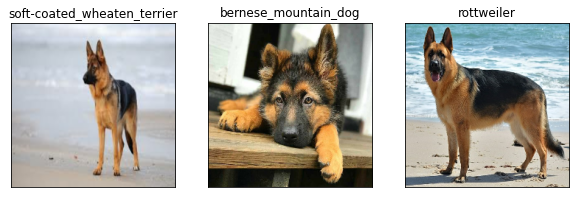

In [151]:
# Check custom image predictions
plt.figure(figsize= (10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)

# The END